## Loading Libraries and Dependencies

In [219]:
import pymc3 as pm
import arviz as az
import pandas as pd
import numpy as np
from scipy.special import kl_div
from scipy.stats import wasserstein_distance
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)

### Loading Drive Locations

In [2]:
drive_stem = '/Users/cory-yemen/'
simulated_data_filepath = 'Downloads/'
josh_file = 'simulated_data.xlsx'

## Reading Data from Drive

In [4]:
df = pd.read_excel(drive_stem + simulated_data_filepath + josh_file)
df.head()

,Parcel_ID,Neighborhood,Living_Area,Year_Built,Mythical_Market_Value,Sale_Price1,Assessed_Value_1,Assessed_Value_2,Assessed_Value_3,Assessed_Value_4,...,Assessed_Value_10,Assessed_Value_11,Assessed_Value_12,Sale_Price3,Assessed_Value_13,Assessed_Value_14,Assessed_Value_15,Assessed_Value_16,Assessed_Value_17,Assessed_Value_18
0,3.124069e+07,5,1133,1963.863994,267430.251558,273438.651191,308208.857140,256755.712330,262506.506830,240988.023994,...,224400.584219,246743.970068,229240.193380,282977.112534,281568.632350,249395.763770,280212.179015,231928.124690,229108.732339,213630.765561
1,3.976991e+07,11,2014,1974.133852,369957.417019,350535.102308,340440.446331,390435.334291,350043.891790,328871.739645,...,331193.943223,373185.107650,341805.389240,359119.061921,382838.132259,430976.078904,359465.970046,344872.498104,309643.089177,358671.004983
2,5.582827e+07,11,3888,1945.415985,563567.297395,604362.986680,537481.927147,580696.995910,522941.329032,563249.309998,...,610295.076939,588361.283721,567384.267575,613878.781720,629174.880669,639472.055845,560064.929241,637266.325279,608454.269799,561764.166440
3,8.265662e+07,1,986,1930.568181,249340.754328,285229.107087,242487.325298,230471.400511,254622.853870,215442.863082,...,212179.986711,211238.865937,224953.368212,232727.258278,228207.693800,243928.032750,290440.543866,215675.356129,219947.473851,246344.018663
4,2.613455e+07,6,2004,1941.443169,341674.191826,342362.882905,319563.923202,354865.690869,355118.667348,383221.765334,...,395187.201998,363608.300563,404405.966881,334045.174873,391726.944670,333554.865827,368008.560921,397075.660220,334881.245048,369215.566569


### Defining Functions to Calculate Key Variables

In [5]:
# Add the sale ratio to the dataframe
def createASR(df, sale_col, assessed_col):

    df = df.assign(asr = lambda x: np.divide(x[sale_col], x[assessed_col]))

    return df

# Return the median ratio
def createMedianValue(df, sale_col, assessed_col):

    medianASR = np.median(np.divide(df[sale_col], df[assessed_col]))

    return medianASR

# Add PRB dependent and independent variables to the dataframe
def createPRBVars(df, sale_col, assessed_col):

    df = createASR(df, sale_col, assessed_col)

    medianASR = createMedianValue(df, sale_col, assessed_col)

    df = df.assign(prbIV = lambda x: np.log((x[sale_col] + x[assessed_col]/2)/np.log(2)), 
                   prbDV = lambda x: np.divide(x.asr - medianASR, medianASR)
                   )
    
    return df

In [208]:
def create_dist_dataframe(val_array, min_val, max_val):

    range_array = (np.arange(min_val, max_val,.001) * 1000).astype(int)
    base_df = pd.DataFrame({'value': range_array, 
                            'count2': np.zeros(range_array.shape[0])}
                           )
    count_df = pd.Series((np.round(val_array, 3) * 1000).astype(int))\
        .value_counts()\
        .reset_index()\
        .rename(columns = {'index': 'value', 0: 'count1'})

    out_df = pd.merge(base_df, count_df, on = 'value', how = 'outer', indicator = True)\
        .assign(count = lambda x: np.where(x.count1 != x.count1, x.count2, x.count1).astype(int), 
                value = lambda x: np.divide(x.value, 1000))
        
    out_df['p'] = out_df['count']/out_df['count'].sum()

    return out_df.set_index('value')[['count', 'p']]


def get_min_max_vals(posterior_obs):
    
    posterior = np.concatenate(posterior_obs, axis=None)
    max_val = posterior.max()
    min_val = posterior.min()
    
    add_factor = abs(max_val - min_val) * .01
    max_val = max_val + add_factor
    min_val = min_val - add_factor
            
    return max_val, min_val


def create_dists_from_vals(vals_dict):        
    
    out_dict = {}
    max_val, min_val = get_min_max_vals([vals_dict['ref_dist']] + vals_dict['cand_dists'])

    out_dict['ref_dist'] = create_dist_dataframe(vals_dict['ref_dist'], min_val, max_val)
    
    for i in range(len(vals_dict['cand_dists'])):
        
        out_dict['cand_dist_' + str(i + 1)] = create_dist_dataframe(vals_dict['cand_dists'][i], min_val, max_val)
        i += 1

    return out_dict

def create_plot_df(prob_dict):
    
    key_map = {'ref_dist': 'MV1', 
               'cand_dist_1': 'MV2', 
               'cand_dist_2': 'MV3', 
               'cand_dist_3': 'MV4', 
               'cand_dist_4': 'MV5',
               'cand_dist_5': 'MV6'
              }
    
    out_df = None
    
    for key in prob_dict:
        
        prob_dict[key] = prob_dict[key].assign(distribution = key_map[key])
        
        if out_df is None:
            
            out_df = prob_dict[key].reset_index()
            
        else:
            
            out_df = pd.concat([out_df, prob_dict[key].reset_index()], ignore_index = True)
            
    return out_df

# Caculate Results

## PRB

#### Set $\sigma$ Priors

In [84]:
sigma_priors = {'regression': .5, 'coefficients': 5}

### Market Value and AV2

In [85]:
df_ref = createPRBVars(df, 'Mythical_Market_Value', 'Assessed_Value_1')
df_cand = createPRBVars(df, 'Mythical_Market_Value', 'Assessed_Value_2')

X_ref = df_ref.prbIV.to_numpy()
Y_ref = df_ref.prbDV.to_numpy()

X_cand = df_cand.prbIV.to_numpy()
Y_cand = df_cand.prbDV.to_numpy()

In [86]:
X_ref_ols = sm.add_constant(X_ref)
model = sm.OLS(Y_ref,X_ref_ols)
results = model.fit()
error_std = (Y_ref - results.predict(X_ref_ols)).std()
results.params

array([ 0.22239663, -0.01609991])

In [87]:
np.random.seed(19850421)
with pm.Model() as prb_ref:  
    # priors
    sigma = pm.HalfNormal('sigma', sigma_priors['regression'])
    beta_0 = pm.Normal('Intercept', results.params[0], sigma=sigma_priors['coefficients'])
    beta_1 = pm.Normal('prb_coeff', results.params[1], sigma=sigma_priors['coefficients'])

    # model likelihood
    likelihood = pm.Normal('y', mu=beta_1 * X_ref + beta_0, sigma=sigma, observed=Y_ref)

    prb_ref_trace = pm.sample(draws=5000, 
                              tune=10000, 
                              chains = 4, 
                              discard_tuned_samples=True, 
                              return_inferencedata=True,
                              random_seed=19850421,
                              target_accept=.9
                             )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prb_coeff, Intercept, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 209 seconds.


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'prb_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

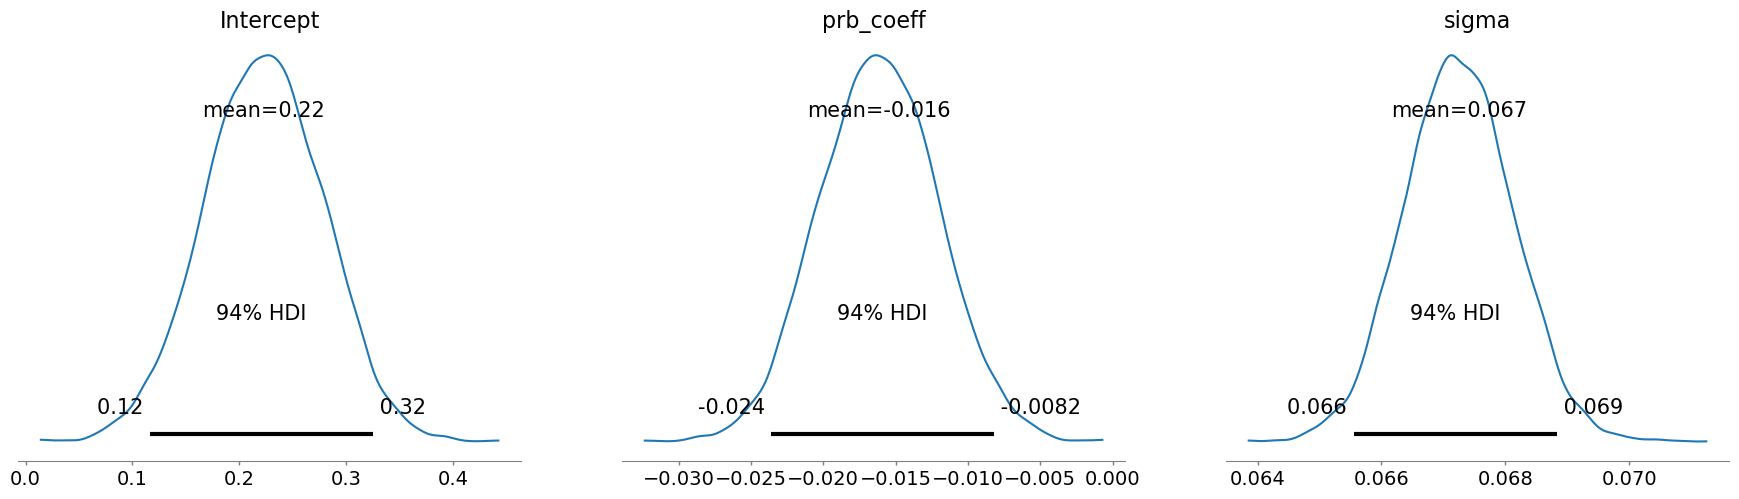

In [88]:
az.plot_posterior(prb_ref_trace)

In [89]:
ref_dist = prb_ref_trace.posterior['prb_coeff'].to_numpy().reshape(-1)

In [90]:
X_cand_ols = sm.add_constant(X_cand)
model = sm.OLS(Y_cand,X_cand_ols)
results = model.fit()
error_std = (Y_cand - results.predict(X_cand_ols)).std()
results.params

array([ 1.77279775, -0.13058201])

In [91]:
np.random.seed(19850421)
with pm.Model() as prb_cand:  
    # Define priors
    sigma = pm.HalfNormal('sigma', sigma_priors['regression'])
    beta_0 = pm.Normal("Intercept", results.params[0], sigma=sigma_priors['coefficients'])
    beta_1 = pm.Normal("prb_coeff", results.params[1], sigma=sigma_priors['coefficients'])

    # Define likelihood
    likelihood = pm.Normal("y", mu=beta_1 * X_cand + beta_0, sigma=sigma, observed=Y_cand)

    prb_cand_trace = pm.sample(draws=5000, 
                               tune=5000, 
                               chains = 4, 
                               discard_tuned_samples=True, 
                               return_inferencedata=True,
                               random_seed=19850421,
                               target_accept=.9
                              )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prb_coeff, Intercept, sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 145 seconds.


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'prb_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

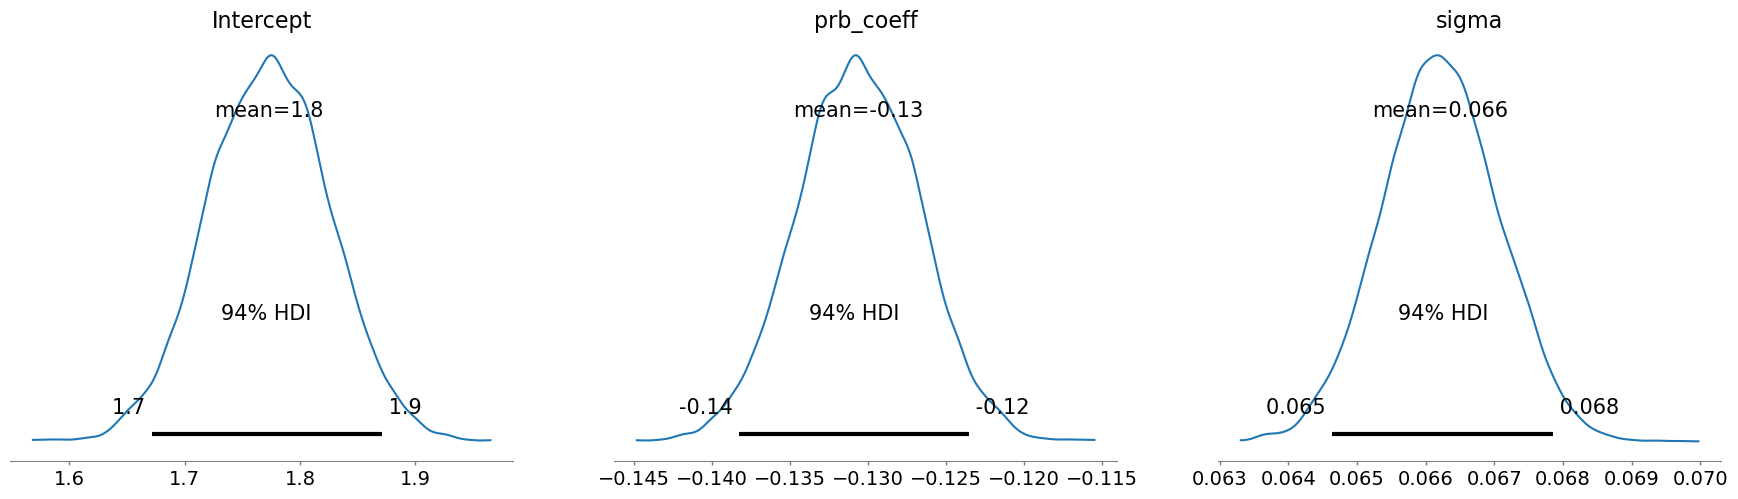

In [92]:
az.plot_posterior(prb_cand_trace)

In [125]:
cand1_dist = prb_cand_trace.posterior['prb_coeff'].to_numpy().reshape(-1)

### Market Value and AV3

In [94]:
df_cand = createPRBVars(df, 'Mythical_Market_Value', 'Assessed_Value_3')

X_cand = df_cand.prbIV.to_numpy()
Y_cand = df_cand.prbDV.to_numpy()

In [95]:
X_cand_ols = sm.add_constant(X_cand)
model = sm.OLS(Y_cand,X_cand_ols)
results = model.fit()
results.params
error_std = (Y_cand - results.predict(X_cand_ols)).std()

In [96]:
np.random.seed(19850421)
with pm.Model() as prb_cand_2:  
    # Define priors
    sigma = pm.HalfNormal('sigma', sigma_priors['regression'])
    beta_0 = pm.Normal("Intercept", results.params[0], sigma=sigma_priors['coefficients'])
    beta_1 = pm.Normal("prb_coeff", results.params[1], sigma=sigma_priors['coefficients'])

    # Define likelihood
    likelihood = pm.Normal("y", mu=beta_1 * X_cand + beta_0, sigma=sigma, observed=Y_cand)

    prb_cand2_trace = pm.sample(draws=5000, 
                                tune=10000, 
                                chains = 4, 
                                discard_tuned_samples=True, 
                                return_inferencedata=True,
                                random_seed=19850421,
                                target_accept=.9
                               )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prb_coeff, Intercept, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 224 seconds.


In [97]:
cand2_dist = prb_cand2_trace.posterior['prb_coeff'].to_numpy().reshape(-1)

/var/folders/zv/mpwg1w512sd35583yr6khgh40000gn/T/ipykernel_2958/1851885863.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(prb_cand2_trace)


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'prb_coeff'}>,
        <AxesSubplot: title={'center': 'prb_coeff'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

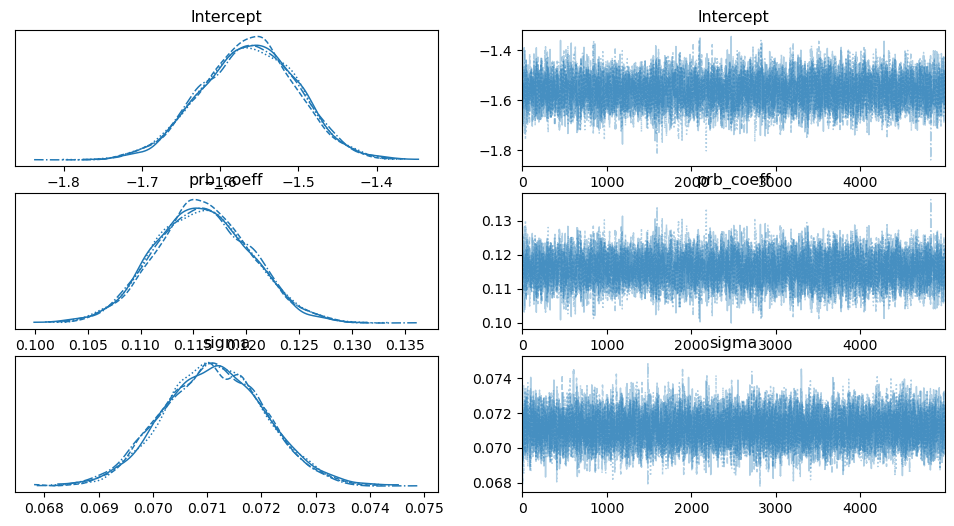

In [98]:
pm.traceplot(prb_cand2_trace)

array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'prb_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

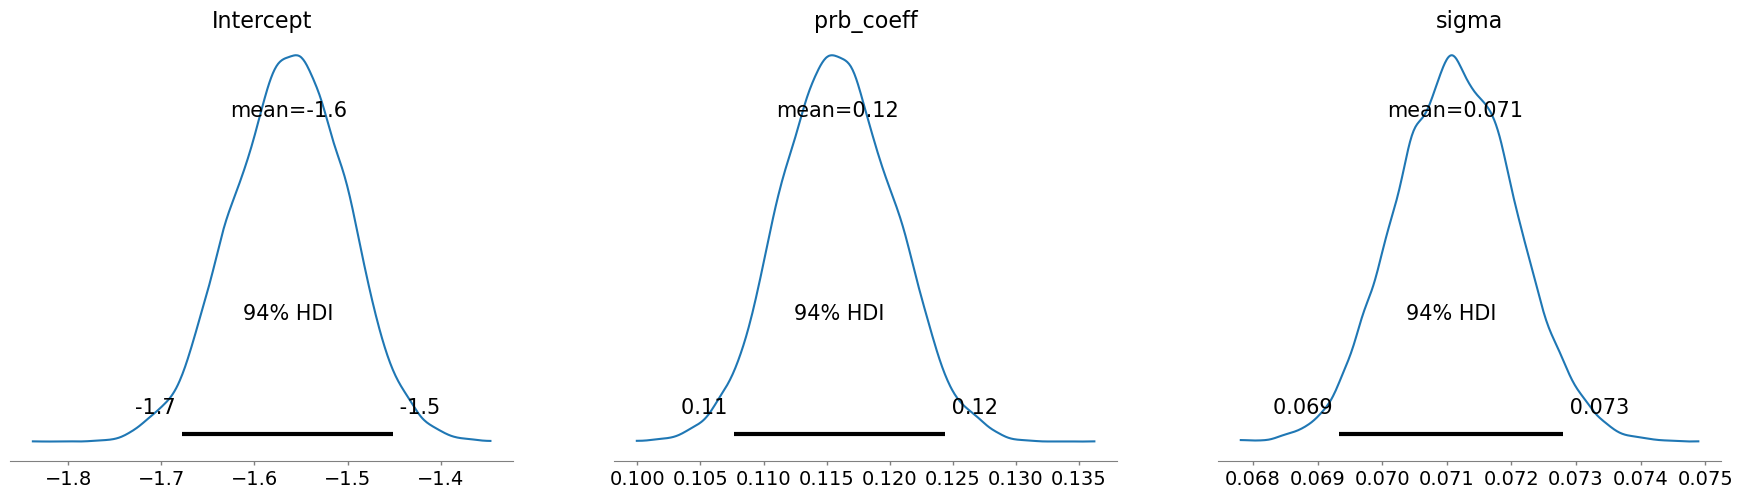

In [99]:
az.plot_posterior(prb_cand2_trace)

### Market Value and AV4

In [100]:
df_cand = createPRBVars(df, 'Mythical_Market_Value', 'Assessed_Value_4')

X_cand = df_cand.prbIV.to_numpy()
Y_cand = df_cand.prbDV.to_numpy()

In [101]:
X_cand_ols = sm.add_constant(X_cand)
model = sm.OLS(Y_cand,X_cand_ols)
results = model.fit()
error_std = (Y_cand - results.predict(X_cand_ols)).std()
results.params

array([ 0.90838067, -0.06691881])

In [102]:
np.random.seed(19850421)
with pm.Model() as prb_cand_3:  
    # Define priors
    sigma = pm.HalfNormal('sigma', sigma_priors['regression'])
    beta_0 = pm.Normal("Intercept", results.params[0], sigma=sigma_priors['coefficients'])
    beta_1 = pm.Normal("prb_coeff", results.params[1], sigma=sigma_priors['coefficients'])

    # Define likelihood
    likelihood = pm.Normal("y", mu=beta_1 * X_cand + beta_0, sigma=sigma, observed=Y_cand)

    prb_cand3_trace = pm.sample(draws=5000, 
                                tune=5000, 
                                chains = 4, 
                                discard_tuned_samples=True, 
                                return_inferencedata=True,
                                random_seed=19850421,
                                target_accept=.9
                               )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prb_coeff, Intercept, sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 149 seconds.


/var/folders/zv/mpwg1w512sd35583yr6khgh40000gn/T/ipykernel_2958/2725892662.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(prb_cand3_trace)


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'prb_coeff'}>,
        <AxesSubplot: title={'center': 'prb_coeff'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

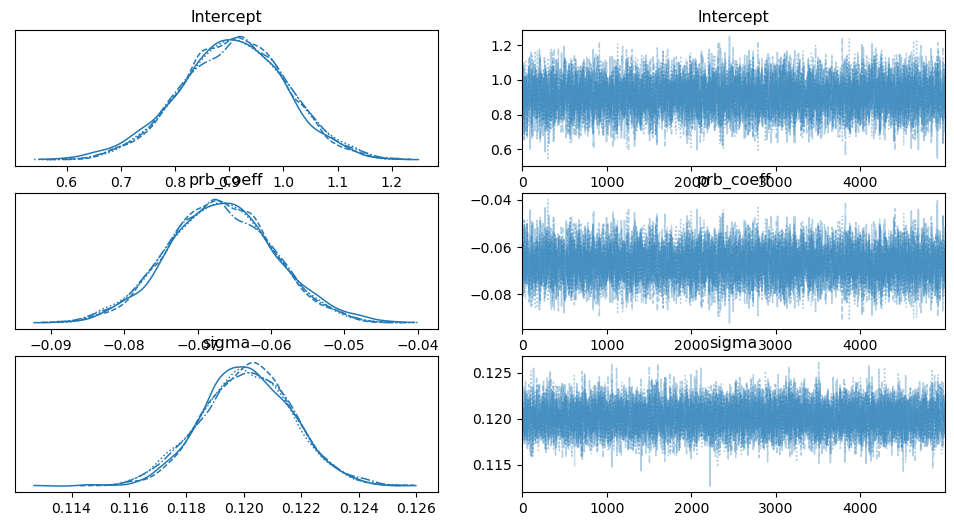

In [103]:
pm.traceplot(prb_cand3_trace)

array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'prb_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

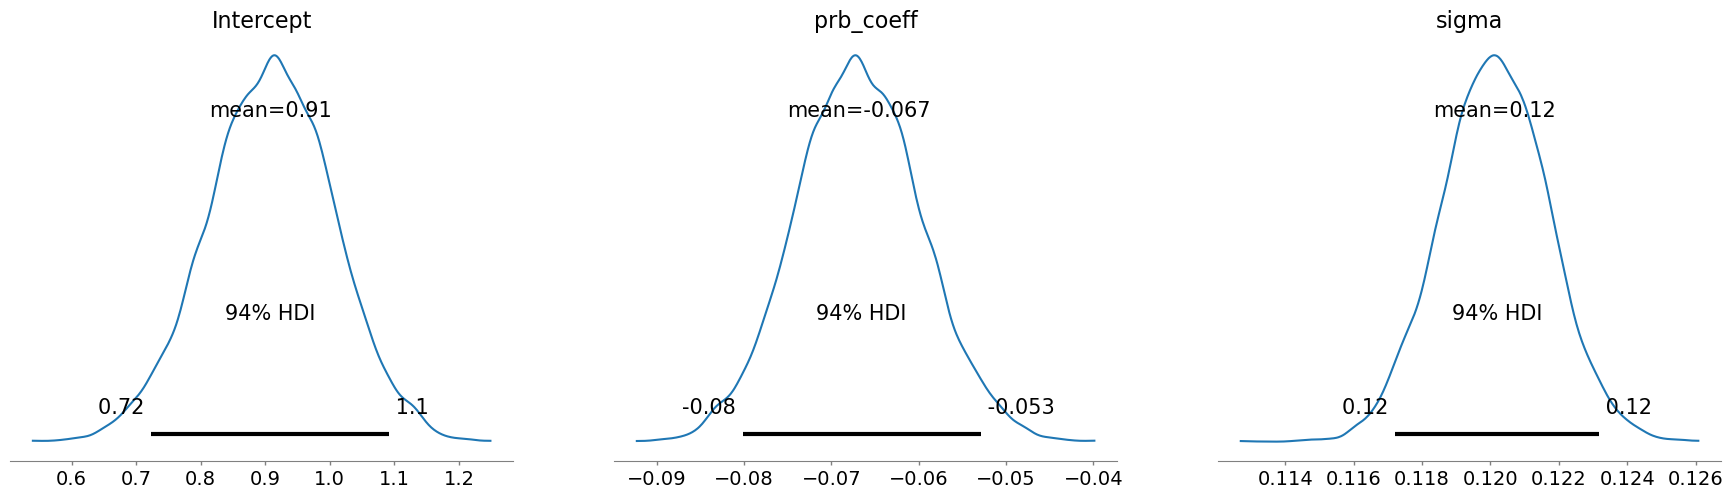

In [104]:
az.plot_posterior(prb_cand3_trace)

In [115]:
cand3_dist = prb_cand3_trace.posterior['prb_coeff'].to_numpy().reshape(-1)

### Market Value and AV5

In [105]:
df_cand = createPRBVars(df, 'Mythical_Market_Value', 'Assessed_Value_5')

X_cand = df_cand.prbIV.to_numpy()
Y_cand = df_cand.prbDV.to_numpy()

In [106]:
X_cand_ols = sm.add_constant(X_cand)
model = sm.OLS(Y_cand,X_cand_ols)
results = model.fit()
results.params
error_std = (Y_cand - results.predict(X_cand_ols)).std()

In [107]:
np.random.seed(19850421)
with pm.Model() as prb_cand_4:  
    # Define priors
    sigma = pm.HalfNormal('sigma', sigma_priors['regression'])
    beta_0 = pm.Normal("Intercept", results.params[0], sigma=sigma_priors['coefficients'])
    beta_1 = pm.Normal("prb_coeff", results.params[1], sigma=sigma_priors['coefficients'])

    # Define likelihood
    likelihood = pm.Normal("y", mu=beta_1 * X_cand + beta_0, sigma=sigma, observed=Y_cand)

    prb_cand4_trace = pm.sample(draws=5000, 
                                tune=10000, 
                                chains = 4, 
                                discard_tuned_samples=True, 
                                return_inferencedata=True,
                                random_seed=19850421,
                                target_accept=.9
                               )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prb_coeff, Intercept, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 197 seconds.


/var/folders/zv/mpwg1w512sd35583yr6khgh40000gn/T/ipykernel_2958/3640971058.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(prb_cand4_trace)


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'prb_coeff'}>,
        <AxesSubplot: title={'center': 'prb_coeff'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

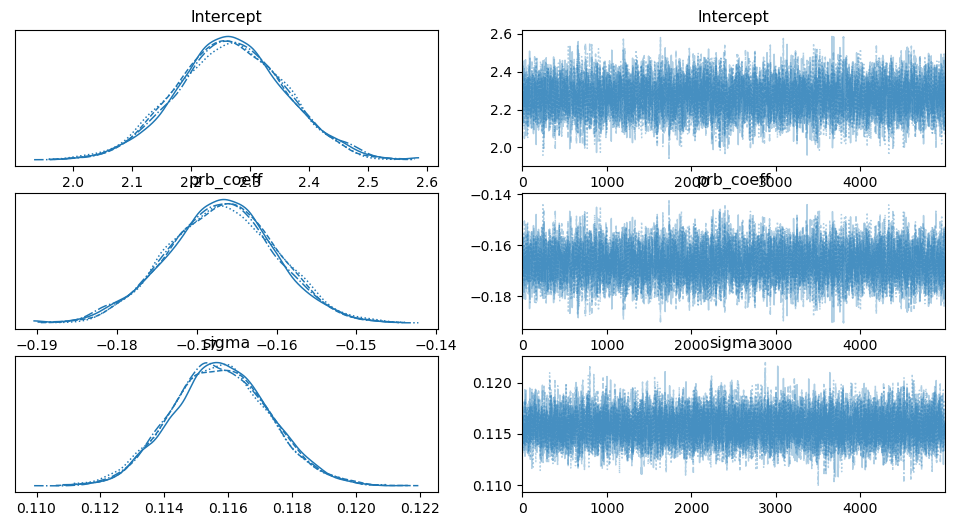

In [108]:
pm.traceplot(prb_cand4_trace)

array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'prb_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

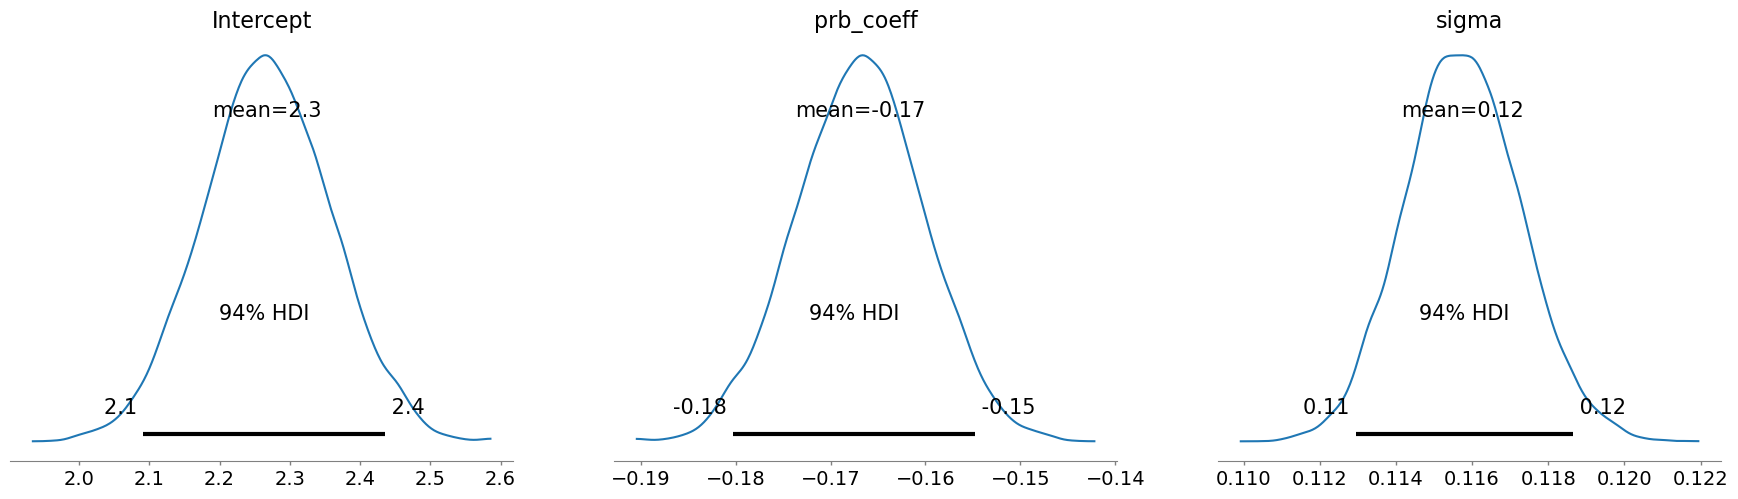

In [109]:
az.plot_posterior(prb_cand4_trace)

In [116]:
cand4_dist = prb_cand4_trace.posterior['prb_coeff'].to_numpy().reshape(-1)

### Market Value and AV6

In [110]:
df_cand = createPRBVars(df, 'Mythical_Market_Value', 'Assessed_Value_6')

X_cand = df_cand.prbIV.to_numpy()
Y_cand = df_cand.prbDV.to_numpy()

In [111]:
X_cand_ols = sm.add_constant(X_cand)
model = sm.OLS(Y_cand,X_cand_ols)
results = model.fit()
results.params
error_std = (Y_cand - results.predict(X_cand_ols)).std()

In [112]:
np.random.seed(19850421)
with pm.Model() as prb_cand_5:  
    # Define priors
    sigma = pm.HalfNormal('sigma', sigma_priors['coefficients'])
    beta_0 = pm.Normal("Intercept", results.params[0], sigma=sigma_priors['coefficients'])
    beta_1 = pm.Normal("prb_coeff", results.params[1], sigma=sigma_priors['coefficients'])

    # Define likelihood
    likelihood = pm.Normal("y", mu=beta_1 * X_cand + beta_0, sigma=sigma, observed=Y_cand)

    prb_cand5_trace = pm.sample(draws=5000, 
                                tune=10000, 
                                chains = 4, 
                                discard_tuned_samples=True, 
                                return_inferencedata=True,
                                random_seed=19850421,
                                target_accept=.9
                               )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prb_coeff, Intercept, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 210 seconds.
The number of effective samples is smaller than 25% for some parameters.


/var/folders/zv/mpwg1w512sd35583yr6khgh40000gn/T/ipykernel_2958/430707968.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(prb_cand5_trace)


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'prb_coeff'}>,
        <AxesSubplot: title={'center': 'prb_coeff'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

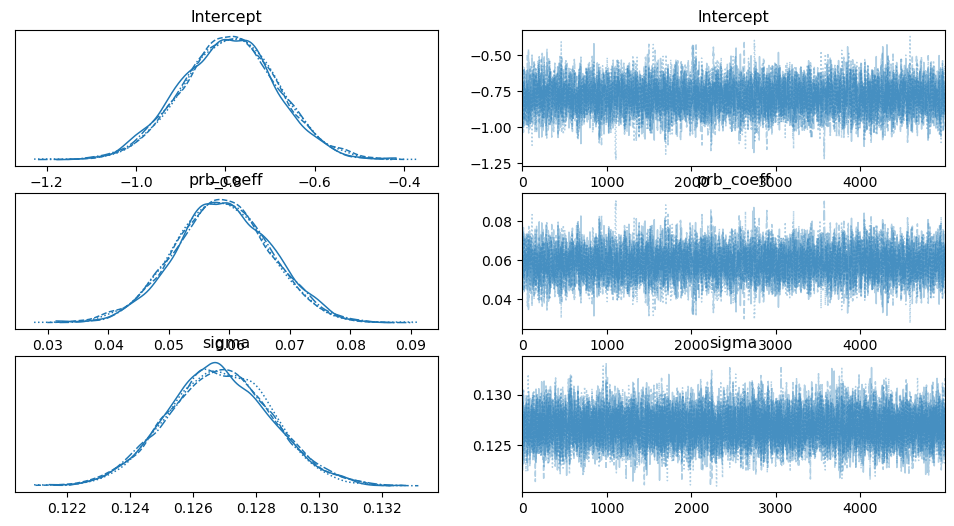

In [113]:
pm.traceplot(prb_cand5_trace)

array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'prb_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

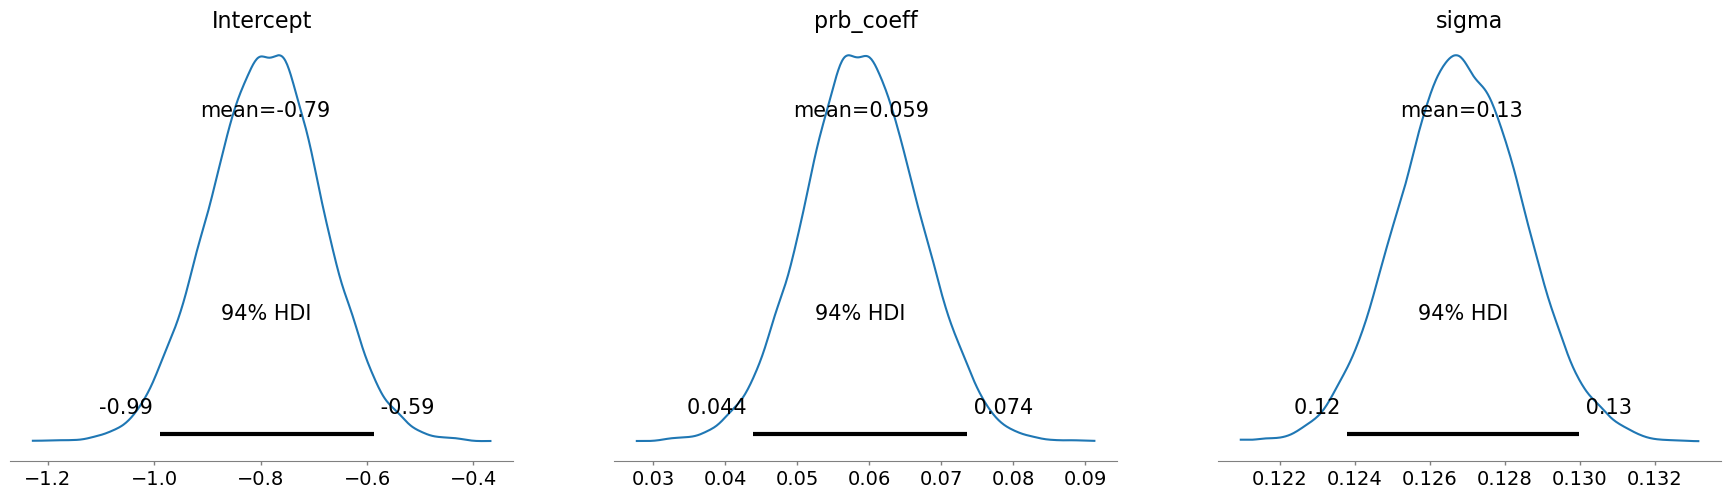

In [114]:
az.plot_posterior(prb_cand5_trace)

In [117]:
cand5_dist = prb_cand5_trace.posterior['prb_coeff'].to_numpy().reshape(-1)

### Putting them all together

In [ ]:
prb_dict = {'ref_dist': ref_dist, 'cand_dists': [cand1_dist, cand2_dist, cand3_dist, cand4_dist, cand5_dist]}

In [290]:
prb_dists = create_dists_from_vals(prb_dict)
prb_out = create_plot_df(prb_dists)

print('KL Divergence: {}'.format(sum(kl_div(prb_dists['ref_dist'].p, prb_dists['cand_dist_4'].p))))
print('Wasserstein Distance: {}'.format(wasserstein_distance(prb_dists['ref_dist'].p, prb_dists['cand_dist_4'].p)))

KL Divergence: inf
Wasserstein Distance: 0.0013970059880239517


<AxesSubplot: xlabel='value', ylabel='p'>

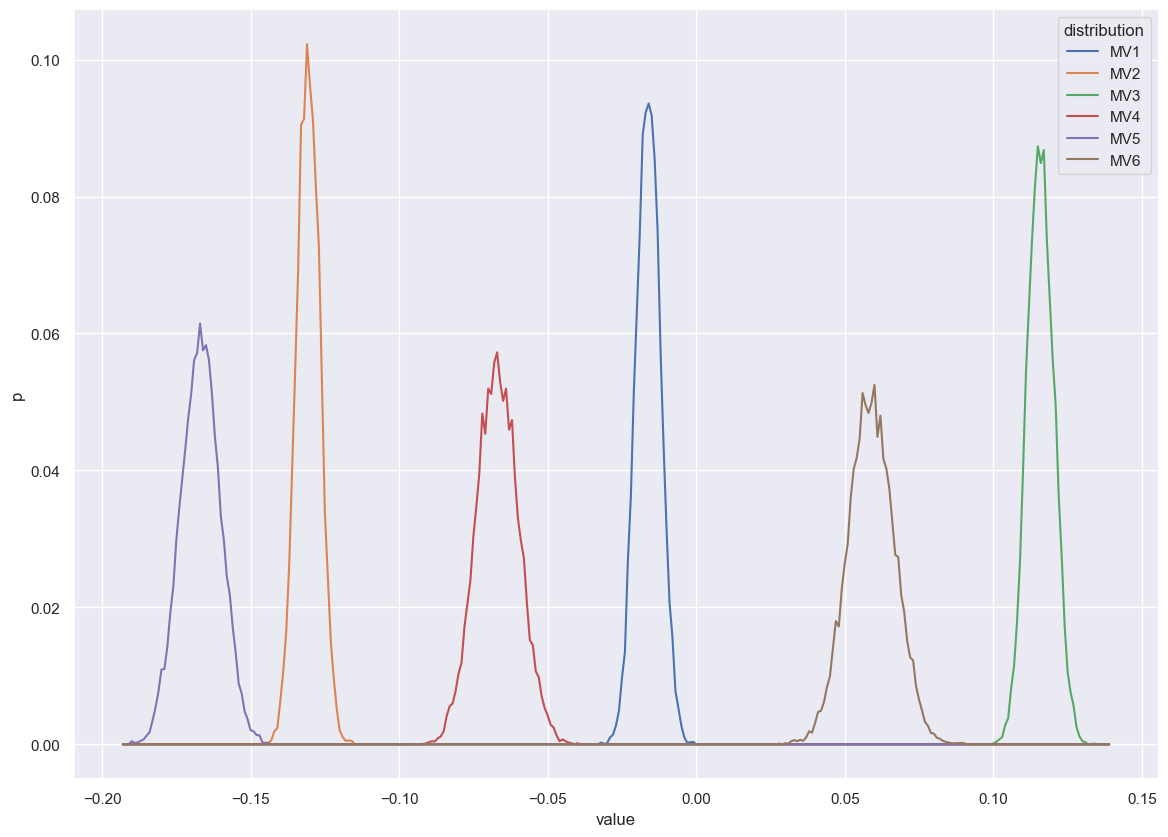

In [236]:
plt.figure(figsize=(14,10))
sns.lineplot(x = 'value', y = 'p', hue = 'distribution', data = out_test)

## PRD

## Paglin & Fogarty
$AV = \beta_{0} + \beta_{1}SP + \epsilon$

Set $\sigma$ priors

In [243]:
sigma_priors = {'coefficient': 5, 'intercept': 5000}

### MV and AV1

In [238]:
df_ref = createPRBVars(df, 'Mythical_Market_Value', 'Assessed_Value_1')

X_ref = df_ref['Mythical_Market_Value'].to_numpy()
Y_ref = df_ref['Assessed_Value_1'].to_numpy()

In [241]:
X_ref_ols = sm.add_constant(X_ref)
model = sm.OLS(Y_ref,X_ref_ols)
results = model.fit()
error_std = (Y_ref - results.predict(X_ref_ols)).std()
results.params
#error_std

array([1.45886991e+03, 9.96368793e-01])

In [244]:
np.random.seed(19850421)
with pm.Model() as pf_ref:  
    # priors
    sigma = pm.HalfNormal('sigma', error_std * 2)
    beta_0 = pm.Normal('Intercept', results.params[0], sigma=sigma_priors['coefficient'])
    beta_1 = pm.Normal('pf_coeff', 1, sigma=sigma_priors['intercept'])

    # model likelihood
    likelihood = pm.Normal('y', mu=beta_1 * X_ref + beta_0, sigma=sigma, observed=Y_ref)

    pf_ref_trace = pm.sample(draws=5000, 
                             tune=10000, 
                             chains = 4,
                             discard_tuned_samples=True, 
                             return_inferencedata=True,
                             random_seed=19850421,
                             target_accept=.9
                             )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pf_coeff, Intercept, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 35 seconds.


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'pf_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

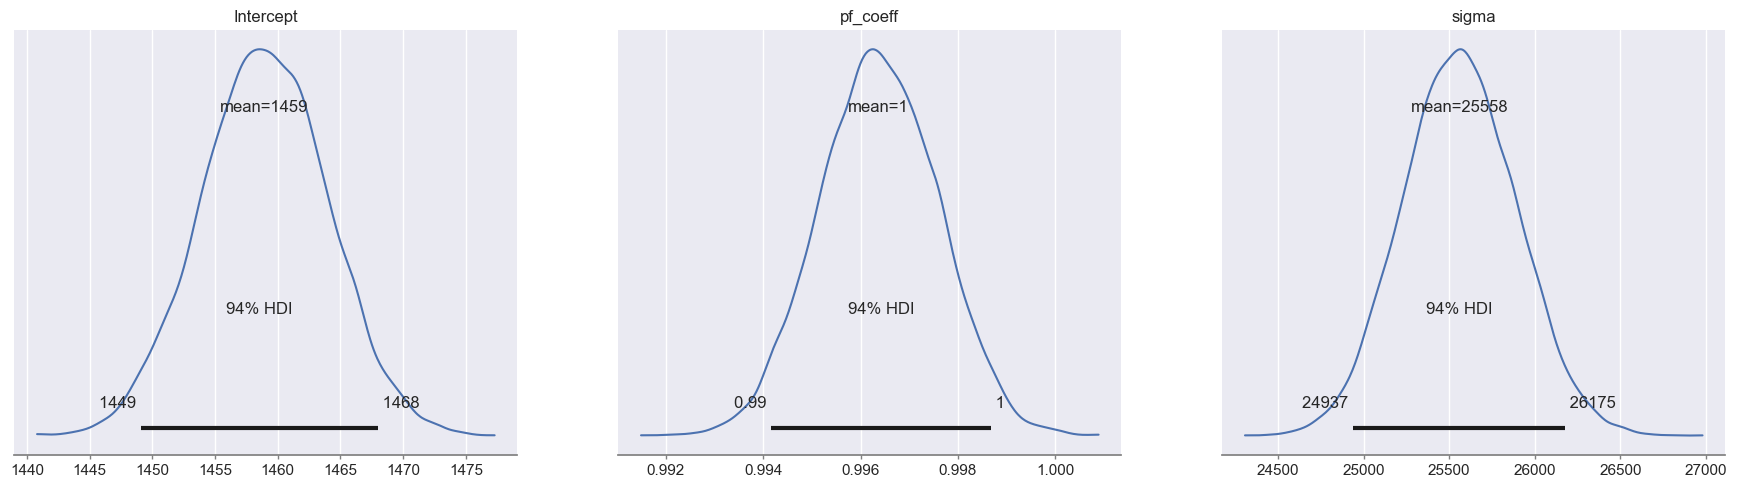

In [245]:
az.plot_posterior(pf_ref_trace)

In [247]:
ref_dist = pf_ref_trace.posterior['pf_coeff'].to_numpy().reshape(-1)

### MV and AV2

In [248]:
X_cand = df_ref['Mythical_Market_Value'].to_numpy()
Y_cand = df_ref['Assessed_Value_2'].to_numpy()

In [249]:
X_cand_ols = sm.add_constant(X_cand)
model = sm.OLS(Y_cand,X_cand_ols)
results = model.fit()
error_std = (Y_cand - results.predict(X_cand_ols)).std()
results.params

array([-5.30142071e+04,  1.15434655e+00])

In [250]:
np.random.seed(19850421)
with pm.Model() as pf_cand_1:  
    # priors
    sigma = pm.HalfNormal('sigma', error_std * 2)
    beta_0 = pm.Normal('Intercept', results.params[0], sigma=sigma_priors['coefficient'])
    beta_1 = pm.Normal('pf_coeff', 1, sigma=sigma_priors['intercept'])

    # model likelihood
    likelihood = pm.Normal('y', mu=beta_1 * X_cand + beta_0, sigma=sigma, observed=Y_cand)

    pf_cand1_trace = pm.sample(draws=5000, 
                               tune=10000, 
                               chains = 4,
                               discard_tuned_samples=True, 
                               return_inferencedata=True,
                               random_seed=19850421,
                               target_accept=.9
                              )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pf_coeff, Intercept, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 21 seconds.


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'pf_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

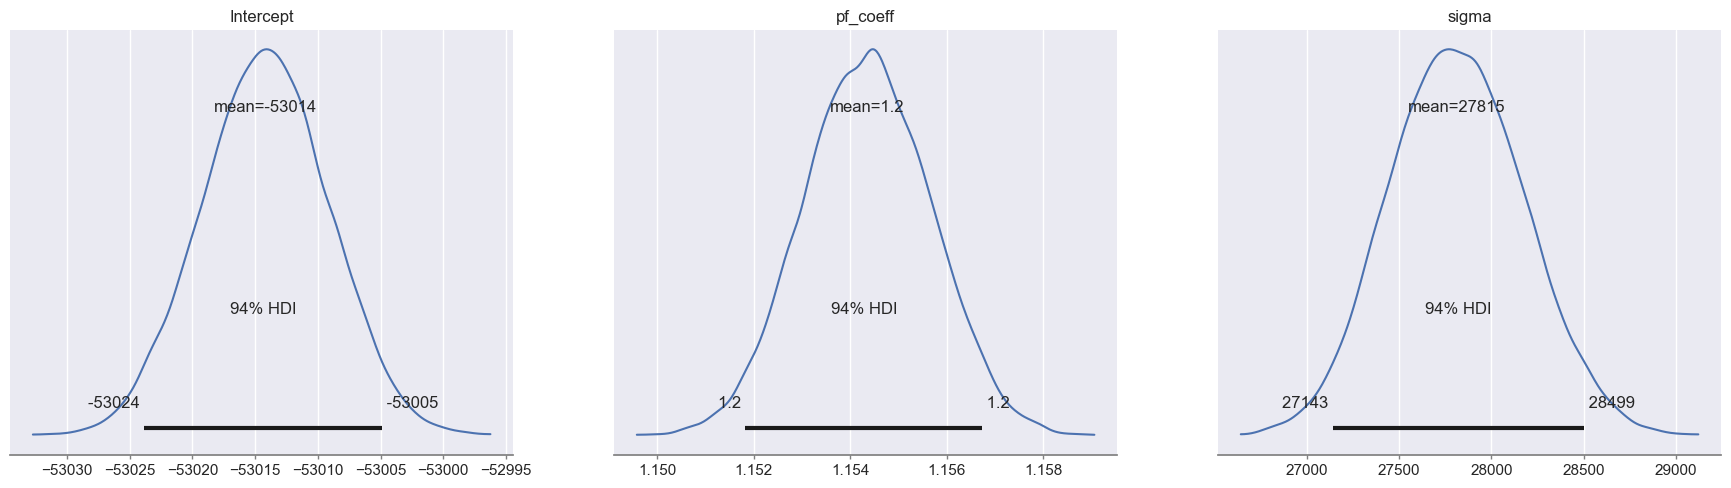

In [251]:
az.plot_posterior(pf_cand1_trace)

In [252]:
cand1_dist = pf_cand1_trace.posterior['pf_coeff'].to_numpy().reshape(-1)

### MV and AV3

In [254]:
Y_cand = df_ref['Assessed_Value_3'].to_numpy()

In [255]:
model = sm.OLS(Y_cand,X_cand_ols)
results = model.fit()
error_std = (Y_cand - results.predict(X_cand_ols)).std()
results.params

array([5.55789884e+04, 8.38785894e-01])

In [256]:
np.random.seed(19850421)
with pm.Model() as pf_cand_2:  
    # priors
    sigma = pm.HalfNormal('sigma', error_std * 2)
    beta_0 = pm.Normal('Intercept', results.params[0], sigma=sigma_priors['coefficient'])
    beta_1 = pm.Normal('pf_coeff', 1, sigma=sigma_priors['intercept'])

    # model likelihood
    likelihood = pm.Normal('y', mu=beta_1 * X_cand + beta_0, sigma=sigma, observed=Y_cand)

    pf_cand2_trace = pm.sample(draws=5000, 
                               tune=10000, 
                               chains = 4,
                               discard_tuned_samples=True, 
                               return_inferencedata=True,
                               random_seed=19850421,
                               target_accept=.9
                              )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pf_coeff, Intercept, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 21 seconds.


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'pf_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

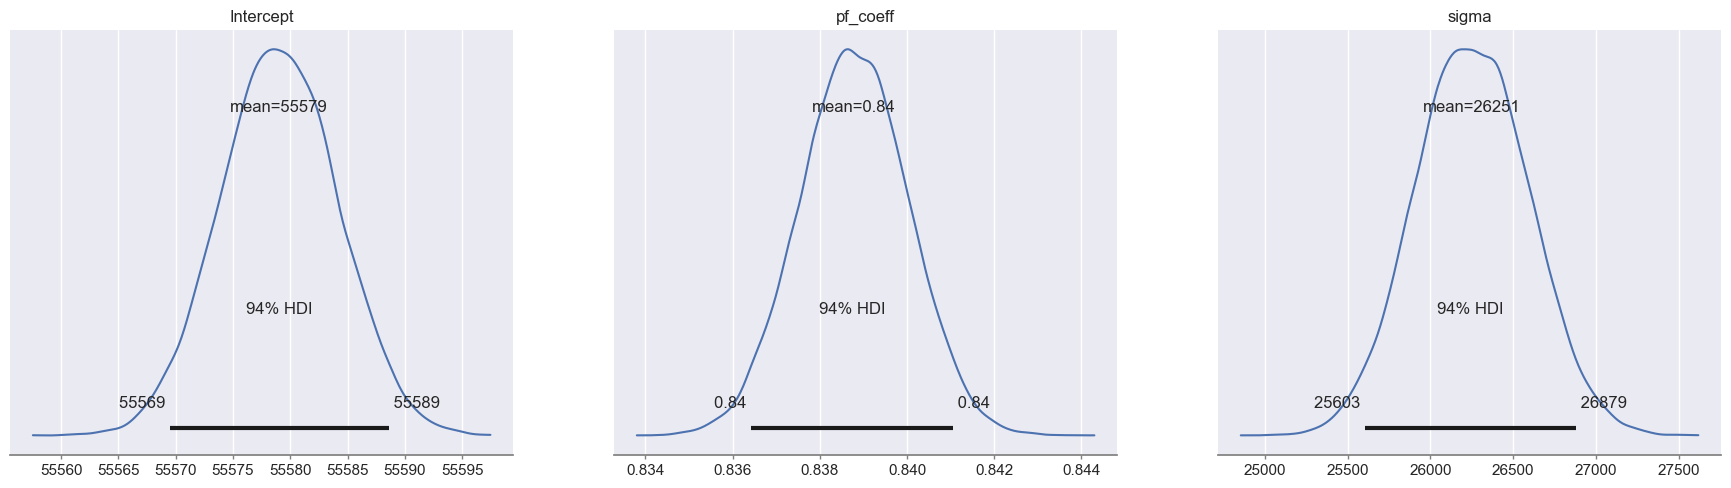

In [257]:
az.plot_posterior(pf_cand2_trace)

In [258]:
cand2_dist = pf_cand2_trace.posterior['pf_coeff'].to_numpy().reshape(-1)

### MV and AV4

In [259]:
Y_cand = df_ref['Assessed_Value_4'].to_numpy()

In [260]:
model = sm.OLS(Y_cand,X_cand_ols)
results = model.fit()
error_std = (Y_cand - results.predict(X_cand_ols)).std()
results.params

array([-79.38340812,   0.99951778])

In [261]:
np.random.seed(19850421)
with pm.Model() as pf_cand_3:  
    # priors
    sigma = pm.HalfNormal('sigma', error_std * 2)
    beta_0 = pm.Normal('Intercept', results.params[0], sigma=sigma_priors['coefficient'])
    beta_1 = pm.Normal('pf_coeff', 1, sigma=sigma_priors['intercept'])

    # model likelihood
    likelihood = pm.Normal('y', mu=beta_1 * X_cand + beta_0, sigma=sigma, observed=Y_cand)

    pf_cand3_trace = pm.sample(draws=5000, 
                               tune=10000, 
                               chains = 4,
                               discard_tuned_samples=True, 
                               return_inferencedata=True,
                               random_seed=19850421,
                               target_accept=.9
                              )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pf_coeff, Intercept, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 23 seconds.


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'pf_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

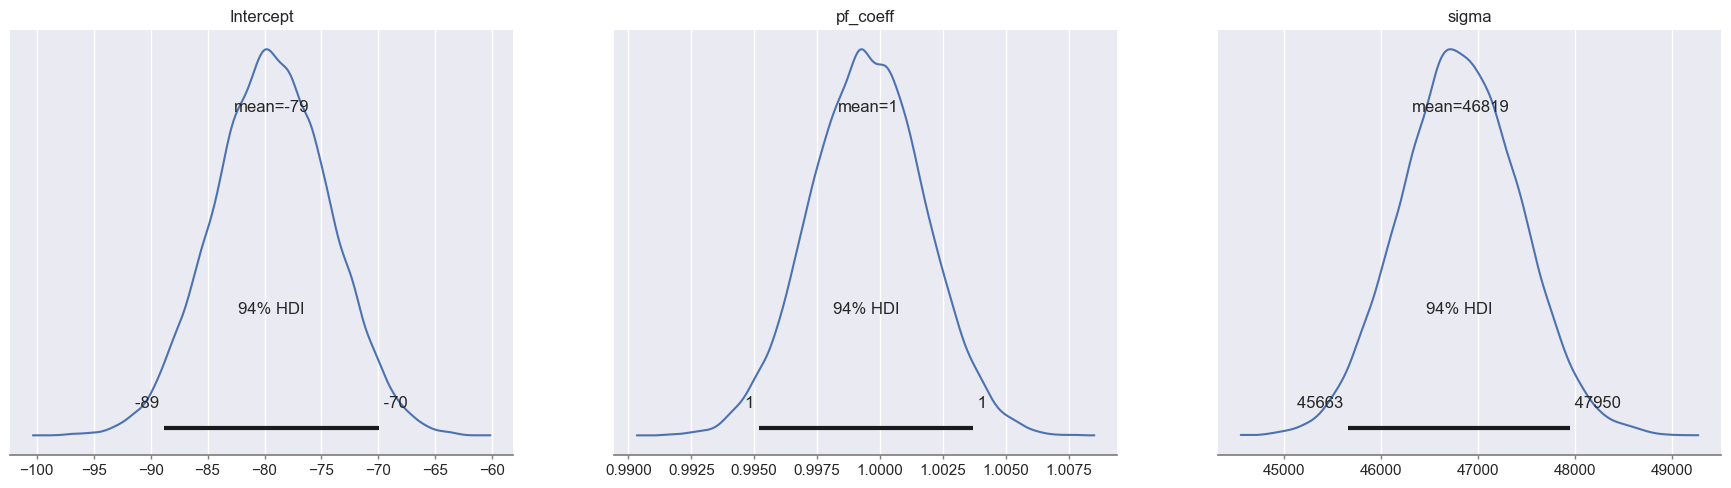

In [262]:
az.plot_posterior(pf_cand3_trace)

In [263]:
cand3_dist = pf_cand3_trace.posterior['pf_coeff'].to_numpy().reshape(-1)

### MV and AV5

In [272]:
Y_cand = df_ref['Assessed_Value_5'].to_numpy()
model = sm.OLS(Y_cand,X_cand_ols)
results = model.fit()
error_std = (Y_cand - results.predict(X_cand_ols)).std()
results.params

array([-5.06868831e+04,  1.14732919e+00])

In [273]:
np.random.seed(19850421)
with pm.Model() as pf_cand_4:  
    # priors
    sigma = pm.HalfNormal('sigma', error_std * 2)
    beta_0 = pm.Normal('Intercept', results.params[0], sigma=sigma_priors['coefficient'])
    beta_1 = pm.Normal('pf_coeff', 1, sigma=sigma_priors['intercept'])

    # model likelihood
    likelihood = pm.Normal('y', mu=beta_1 * X_cand + beta_0, sigma=sigma, observed=Y_cand)

    pf_cand4_trace = pm.sample(draws=5000, 
                               tune=10000, 
                               chains = 4,
                               discard_tuned_samples=True, 
                               return_inferencedata=True,
                               random_seed=19850421,
                               target_accept=.9
                              )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pf_coeff, Intercept, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 21 seconds.


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'pf_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

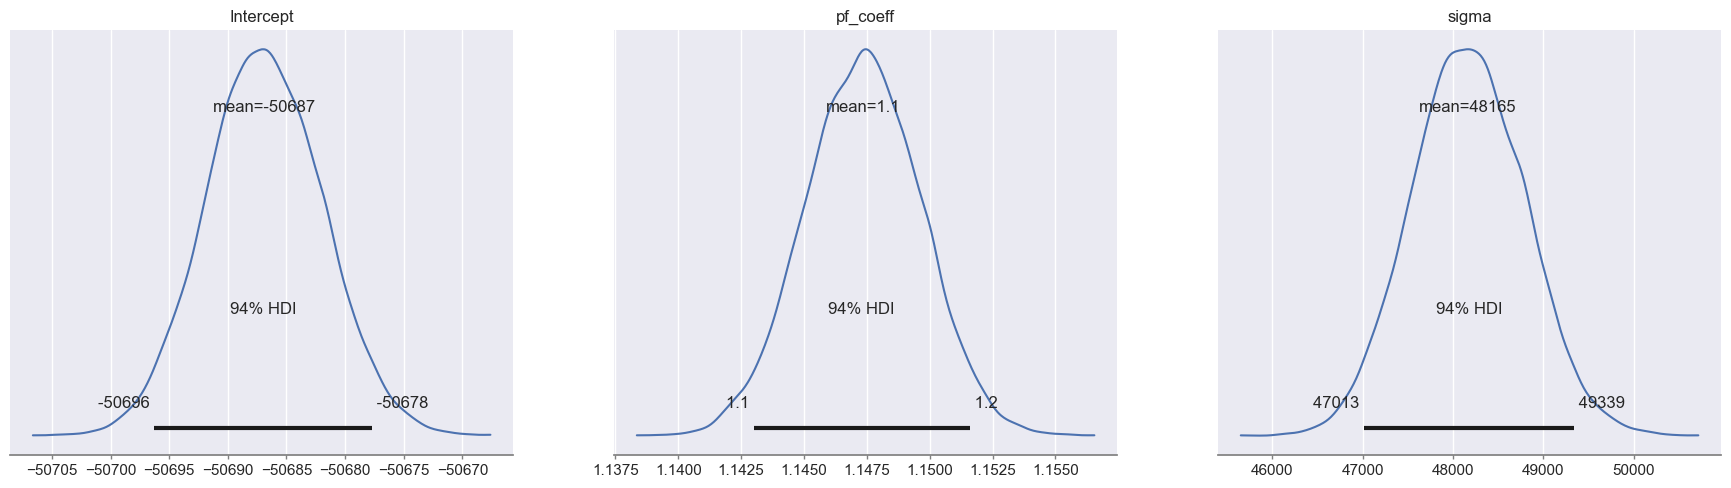

In [274]:
az.plot_posterior(pf_cand4_trace)

In [283]:
cand4_dist = pf_cand4_trace.posterior['pf_coeff'].to_numpy().reshape(-1)

### MV and AV6

In [276]:
Y_cand = df_ref['Assessed_Value_6'].to_numpy()
model = sm.OLS(Y_cand,X_cand_ols)
results = model.fit()
error_std = (Y_cand - results.predict(X_cand_ols)).std()
results.params

array([5.44527748e+04, 8.41165786e-01])

In [277]:
np.random.seed(19850421)
with pm.Model() as pf_cand_5:  
    # priors
    sigma = pm.HalfNormal('sigma', error_std * 2)
    beta_0 = pm.Normal('Intercept', results.params[0], sigma=sigma_priors['coefficient'])
    beta_1 = pm.Normal('pf_coeff', 1, sigma=sigma_priors['intercept'])

    # model likelihood
    likelihood = pm.Normal('y', mu=beta_1 * X_cand + beta_0, sigma=sigma, observed=Y_cand)

    pf_cand5_trace = pm.sample(draws=5000, 
                               tune=10000, 
                               chains = 4,
                               discard_tuned_samples=True, 
                               return_inferencedata=True,
                               random_seed=19850421,
                               target_accept=.9
                              )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pf_coeff, Intercept, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 21 seconds.


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'pf_coeff'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

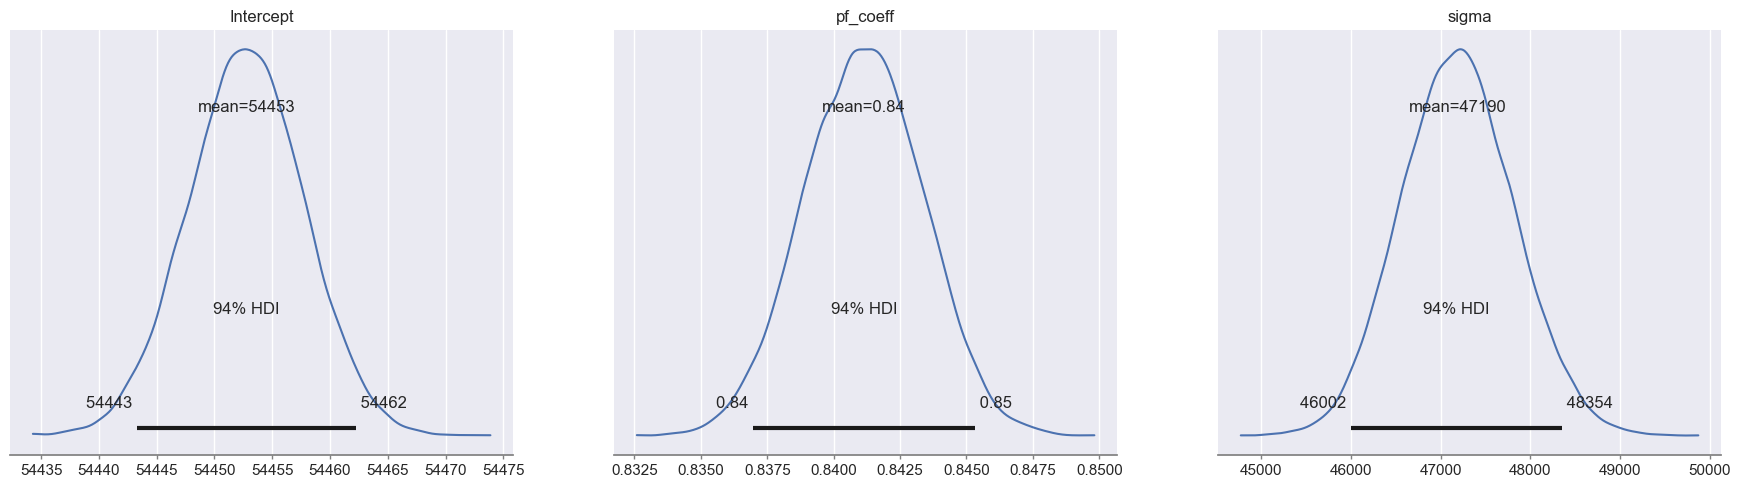

In [278]:
az.plot_posterior(pf_cand5_trace)

In [284]:
cand5_dist = pf_cand5_trace.posterior['pf_coeff'].to_numpy().reshape(-1)

### Putting them all together

In [285]:
pf_dict = {'ref_dist': ref_dist, 'cand_dists': [cand1_dist, cand2_dist, cand3_dist, cand4_dist, cand5_dist]}

In [289]:
pf_dists = create_dists_from_vals(pf_dict)
pf_out = create_plot_df(pf_dists)

print('KL Divergence: {}'.format(sum(kl_div(pf_dists['ref_dist'].p, pf_dists['cand_dist_4'].p))))
print('Wasserstein Distance: {}'.format(wasserstein_distance(pf_dists['ref_dist'].p, pf_dists['cand_dist_4'].p)))

KL Divergence: inf
Wasserstein Distance: 0.0017026946107784476


<AxesSubplot: xlabel='value', ylabel='p'>

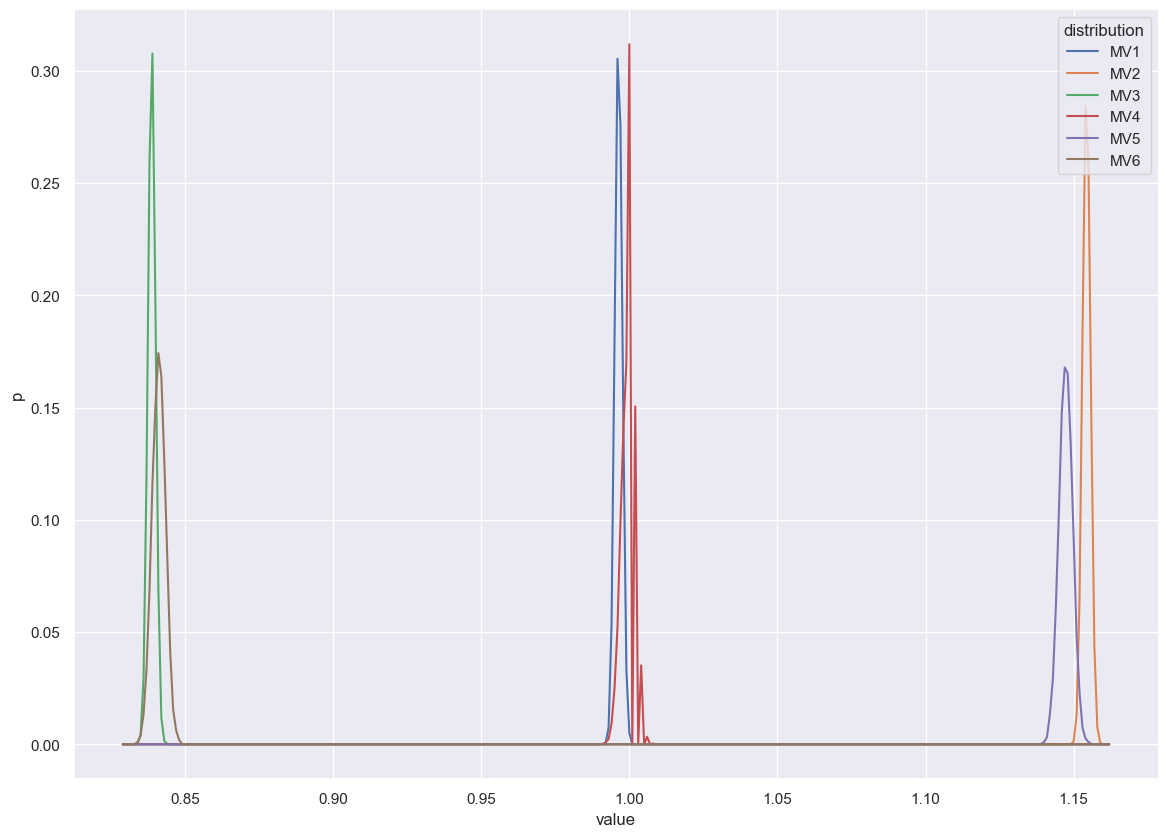

In [287]:
plt.figure(figsize=(14,10))
sns.lineplot(x = 'value', y = 'p', hue = 'distribution', data = pf_out)

## ASR
$\frac{AV}{SP} = \beta_{0} + \beta_{1}SP + \epsilon$

## Cheng
$\ln{(AV)} = \beta_{0} + \beta_{1}\ln{(SP)} + \epsilon$